In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)
# pd.set_option('display.max_colwidth', None)

In [2]:
excel_data_df = pd.ExcelFile(r'../data/sinno.xlsx')
excel_data_df = excel_data_df.parse(excel_data_df.sheet_names[0])

In [3]:
result_df = pd.ExcelFile(r'../data/sinno-result.xlsx')
result_df = result_df.parse(result_df.sheet_names[1])
result_set = result_df.iloc[:, 1].tolist()

In [4]:
# for idx, header in enumerate(excel_data_df.columns.tolist()):
#     print(idx, header)

In [5]:
excel_data_df = excel_data_df[(excel_data_df["11. Bạn mong muốn tham gia vào ban"] == "Nhân sự")]
# excel_data_df = excel_data_df[(excel_data_df["11. Bạn mong muốn tham gia vào ban"] == "Đối ngoại")]
# excel_data_df = excel_data_df[(excel_data_df["11. Bạn mong muốn tham gia vào ban"] == "Chuyên môn")]
# excel_data_df = excel_data_df[(excel_data_df["11. Bạn mong muốn tham gia vào ban"] == "Hậu cần")]
# excel_data_df = excel_data_df[(excel_data_df["11. Bạn mong muốn tham gia vào ban"] == "Truyền thông")]
excel_data_df.reset_index(drop=True, inplace=True)
excel_data_df.fillna("", inplace = True)
# filter = [0, 1, 5, 7, 9, 11, 14, 15, 16, 17, 18, 19, 22, 23, 24, 26, 28, 30, 31, 33, 34, 35, 36, 37, 40, 41, 43, 44, 45, 52, 53, 55, 58, 60, 61, 65, 68, 69, 74, 77, 84, 86, 87, 88, 89, 96, 97, 98, 102, 104, 106, 107, 108, 110, 111, 112, 113, 114, 116, 117, 120, 127, 129, 134, 135, 137, 138, 139, 140, 140, 142, 145, 146, 149, 152, 154, 155]
# excel_data_df = excel_data_df.iloc[filter]
# excel_data_df.reset_index(drop=True, inplace=True)
# identity = list(excel_data_df.index.values)
identity = excel_data_df.iloc[:, 1].tolist()

In [6]:
import sys; sys.path.insert(0, '..')
from app.loader import loader
from app.ssmc_fcm import SSMC_FCM

/home/hoangtc125/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


--- Algo Clustering Config:
 {
    "SERVICE_NAME": "ALGO_CLUSTERING",
    "STOPWORD_PATH": "/media/hoangtc125/E/DATN/algo-clustering-service/resources/vn_stopword.txt",
    "FEATURES_PATH": "/media/hoangtc125/E/DATN/algo-clustering-service/resources/features.txt"
}
No GPU available, using the CPU instead.


Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [7]:
fields_chosen = {
    # # sample data
    # 2: (loader.feature_engineering, 1),

    # # egg data
    # 3: (loader.multilabel_binarizing, 1),
    # 4: (loader.multilabel_binarizing, 1),
    # 5: (loader.feature_engineering, 1),
    # 6: (loader.feature_engineering, 1),
    # 7: (loader.multilabel_binarizing, 1),
    # 8: (loader.multilabel_binarizing, 1),
    # 9: (loader.multilabel_binarizing, 1),
    # 10: (loader.feature_engineering, 1),

    # # nha data BCM
    # 40: (loader.feature_engineering, 1),
    # 43: (loader.feature_engineering, 1),
    # 46: (loader.feature_engineering, 1),
    # 49: (loader.feature_engineering, 1),
    # 55: (loader.feature_engineering, 1),
    # 58: (loader.feature_engineering, 1),

    # # nha data BCT
    # 41: (loader.feature_engineering, 1),
    # 44: (loader.feature_engineering, 1),
    # 47: (loader.feature_engineering, 1),
    # 50: (loader.feature_engineering, 1),
    # 62: (loader.feature_engineering, 1),
    # 65: (loader.feature_engineering, 1),
    # 68: (loader.feature_engineering, 1),
    # 71: (loader.feature_engineering, 1),

    # # nha data BDN
    # 41: (loader.feature_engineering, 1),
    # 44: (loader.feature_engineering, 1),
    # 47: (loader.feature_engineering, 1),
    # 50: (loader.feature_engineering, 1),
    # 74: (loader.feature_engineering, 1),
    # 77: (loader.feature_engineering, 1),
    # 80: (loader.feature_engineering, 1),

    # sinno data nhan su
    10: (loader.feature_engineering, 1),
    18: (loader.feature_engineering, 1),
    19: (loader.feature_engineering, 1),
    20: (loader.multilabel_binarizing, 1),
    21: (loader.feature_engineering, 1),
    34: (loader.multilabel_binarizing, 1),
    35: (loader.feature_engineering, 1),
    36: (loader.feature_engineering, 1),
    37: (loader.feature_engineering, 1),
    38: (loader.feature_engineering, 1),

    # # sinno data doi ngoai
    # 10: (loader.feature_engineering, 1),
    # 29: (loader.feature_engineering, 1),
    # 30: (loader.feature_engineering, 1),
    # 31: (loader.feature_engineering, 1),
    # 32: (loader.feature_engineering, 1),
    # 34: (loader.multilabel_binarizing, 1),
    # 35: (loader.feature_engineering, 1),
    # 36: (loader.feature_engineering, 1),
    # 37: (loader.feature_engineering, 1),
    # 38: (loader.feature_engineering, 1),

    # # sinno data chuyen mon
    # 10: (loader.feature_engineering, 1),
    # 13: (loader.feature_engineering, 1),
    # 14: (loader.feature_engineering, 1),
    # 15: (loader.feature_engineering, 1),
    # 16: (loader.feature_engineering, 1),
    # 17: (loader.feature_engineering, 1),
    # 34: (loader.multilabel_binarizing, 1),
    # 35: (loader.feature_engineering, 1),
    # 36: (loader.feature_engineering, 1),
    # 37: (loader.feature_engineering, 1),
    # 38: (loader.feature_engineering, 1),

    # # sinno data hau can
    # 10: (loader.feature_engineering, 1),
    # 33: (loader.feature_engineering, 1),
    # 39: (loader.feature_engineering, 1),
    # 40: (loader.feature_engineering, 1),
    # 34: (loader.multilabel_binarizing, 1),
    # 35: (loader.feature_engineering, 1),
    # 36: (loader.feature_engineering, 1),
    # 37: (loader.feature_engineering, 1),
    # 38: (loader.feature_engineering, 1),

    # # sinno data truyen thong
    # 10: (loader.feature_engineering, 1),
    # 22: (loader.feature_engineering, 1),
    # 23: (loader.feature_engineering, 1),
    # 24: (loader.feature_engineering, 1),
    # 25: (loader.feature_engineering, 1),
    # 26: (loader.feature_engineering, 1),
    # 34: (loader.multilabel_binarizing, 1),
    # 35: (loader.feature_engineering, 1),
    # 36: (loader.feature_engineering, 1),
    # 37: (loader.feature_engineering, 1),
    # 38: (loader.feature_engineering, 1),
}

In [8]:
from datetime import datetime
vectors = {}
for id_field, config in fields_chosen.items():
    start = datetime.now()
    func = config[0]
    raw_data = excel_data_df.iloc[:, id_field].tolist()
    data = func(raw_data)
    vectors[id_field] = data
    print(f"{round(100 * (list(fields_chosen).index(id_field) + 1) / len(fields_chosen), 2)}% ({datetime.now() - start})")

10.0% (0:00:00.944478)
20.0% (0:00:01.888122)
30.0% (0:00:01.608802)
40.0% (0:00:00.000866)
50.0% (0:00:01.355112)
60.0% (0:00:00.000905)
70.0% (0:00:01.002700)
80.0% (0:00:01.706284)
90.0% (0:00:01.310941)
100.0% (0:00:01.184791)


In [9]:
cluster_fields = list(fields_chosen.keys())
dataset = None
data_field_len = []
data_field_weight = []
for idx, id_field in enumerate(cluster_fields):
    data = np.array(vectors[id_field])
    dataset = data if idx == 0 else np.hstack((dataset, data))
    data_field_len.append(data.shape[1])
    data_field_weight.append(fields_chosen[id_field][1])
dataset.shape, data_field_len, data_field_weight

((30, 6151),
 [768, 768, 768, 3, 768, 4, 768, 768, 768, 768],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

Supervised percentage: 0.0% (0:30)
Cluster members: 
[]
[]
[]
['Đỗ Duy Hùng', 'k', 'Nguyễn Nam Hải', 'Nguyễn Anh Luận', 'Trần Quang Phúc', 'Kim Ngọc Chung', 'Lưu Minh Thắng', 'Nguyễn Thị Hồng Loan', 'Trần Thanh Trường', 'Nguyễn Minh Tú', 'Tạ Hữu Bình', 'Đỗ Thị Ngọc Anh ', 'Nguyễn Xuân Phong', 'Nguyễn Tiến Đức', 'Nguyễn Bảo Ngọc ', 'Hoàng Thị Hằng ', 'Lưu Thị Thu Thảo', 'Vũ Đình Bách']
['Đường Minh Quân', 'Nguyễn Quang Duy', 'Nguyễn Thu Hà', 'Lương Đức Trọng', 'Nguyễn Doãn Tùng Lâm', 'Phạm Tuấn Kiệt', 'Lê Đức Anh ', 'Nguyễn Hoàng Anh', 'Nguyễn Phan Anh', 'Trần Anh Đức', 'Trần Đức Tuấn Kiên', 'Đoàn Thế Vinh']


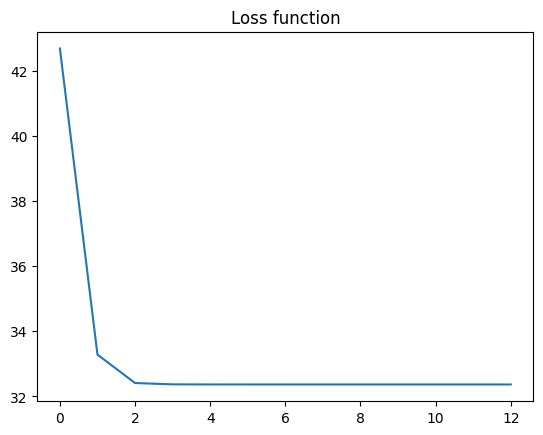

loss functions: 
[42.678584286147, 33.284638402268776, 32.41311134892067, 32.3727772904037, 32.36924739458269, 32.36879470831772, 32.36873104205027, 32.36872191065354, 32.36872059541902, 32.36872040581645, 32.36872037848047, 32.36872037453945, 32.36872037397129]


In [10]:
supervised_set = [
    [
        
    ]
]
ssmc_fcm = SSMC_FCM(
    dataset=dataset, 
    fields_len=data_field_len, 
    fields_weight=data_field_weight,
    # fields_weight=[0, 0, 1, 1, 1, 0, 1, 0, 0, 0],
    n_clusters=5, 
    identity=identity,
    supervised_set=supervised_set, 
)
ssmc_fcm.clustering()
ssmc_fcm.show_cluster_members()
ssmc_fcm.show_loss_function()

In [11]:
identity_mapping = {iden: idx for idx, iden in enumerate(identity)}
for cluster in ssmc_fcm.pred_labels:
    count = sum([cluster.count(x) for x in result_set])
    print(f"Accuracy: {round(100 * count / len(result_set), 2)}% ({count} in {len(cluster)} of {len(ssmc_fcm.dataset)})")
    # print([identity.index(i) for i in cluster])
    # display(excel_data_df.loc[[identity.index(i) for i in cluster]].iloc[:, [1, *cluster_fields]])

Accuracy: 0.0% (0 in 0 of 30)
Accuracy: 0.0% (0 in 0 of 30)
Accuracy: 0.0% (0 in 0 of 30)
Accuracy: 33.33% (2 in 18 of 30)
Accuracy: 66.67% (4 in 12 of 30)


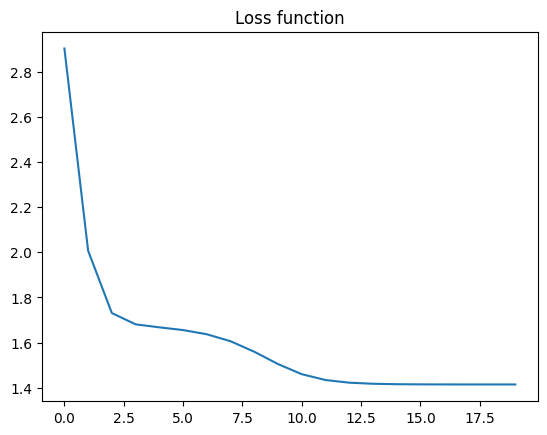

loss functions: 
[2.903399129113063, 2.0068598214074833, 1.7307997624099667, 1.6808303355954985, 1.6674948427386995, 1.6554345391306005, 1.6368789305219975, 1.606018223266133, 1.5594503721941182, 1.5047785123352067, 1.459946591282863, 1.4340633839474966, 1.422259297460692, 1.417418303309389, 1.4154982557869382, 1.4147431088461448, 1.4144466793106996, 1.4143303627830168, 1.4142847237261622, 1.4142668162309444]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0] 0
Accuracy: 16.67% (1 in 5 of 30)
Accuracy: 33.33% (2 in 8 of 30)
Accuracy: 33.33% (2 in 12 of 30)
Accuracy: 0.0% (0 in 0 of 30)
Accuracy: 16.67% (1 in 5 of 30)



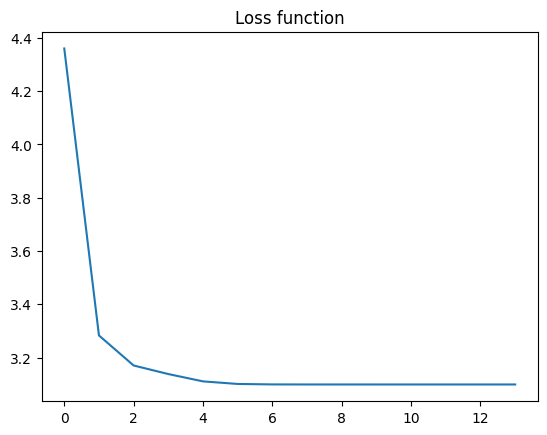

loss functions: 
[4.3601476845477265, 3.2832616997185102, 3.170547652245686, 3.1383628074639907, 3.1108833110624707, 3.101226720635015, 3.0995142717874344, 3.0992907903329256, 3.0992644652251076, 3.0992614683901243, 3.0992611312196496, 3.099261093439874, 3.099261089212711, 3.099261088739973]
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0] 1
Accuracy: 0.0% (0 in 1 of 30)
Accuracy: 0.0% (0 in 0 of 30)
Accuracy: 0.0% (0 in 0 of 30)
Accuracy: 0.0% (0 in 9 of 30)
Accuracy: 100.0% (6 in 20 of 30)



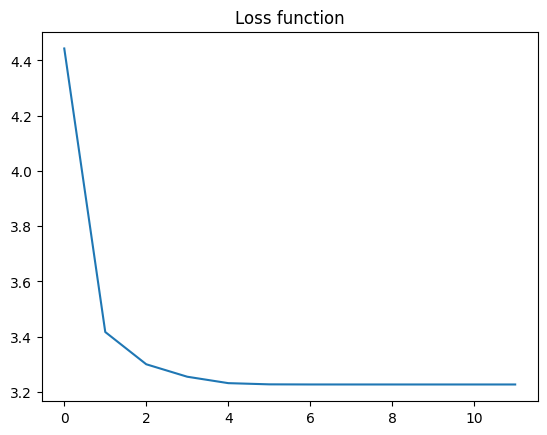

loss functions: 
[4.443273806712325, 3.4167980472592445, 3.2999919165760043, 3.2548737874334974, 3.2316630300407057, 3.227291897414294, 3.2268595240008224, 3.226825124064149, 3.2268225461393936, 3.226822356128838, 3.2268223421895277, 3.226822341168337]
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0] 2
Accuracy: 16.67% (1 in 7 of 30)
Accuracy: 0.0% (0 in 10 of 30)
Accuracy: 16.67% (1 in 1 of 30)
Accuracy: 0.0% (0 in 0 of 30)
Accuracy: 66.67% (4 in 12 of 30)



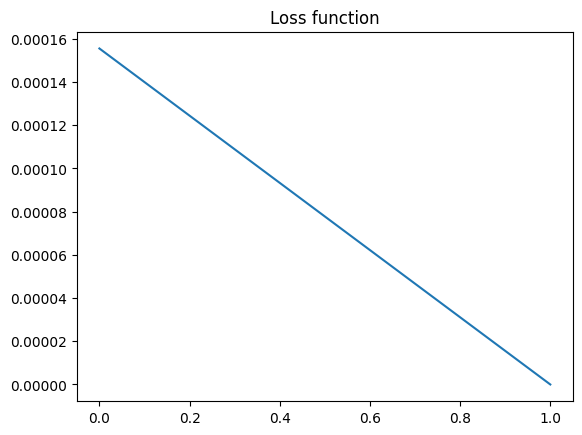

loss functions: 
[0.00015553939033695002, 1.4093769565755372e-09]
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0] 3
Accuracy: 50.0% (3 in 10 of 30)
Accuracy: 33.33% (2 in 14 of 30)
Accuracy: 16.67% (1 in 6 of 30)
Accuracy: 0.0% (0 in 0 of 30)
Accuracy: 0.0% (0 in 0 of 30)



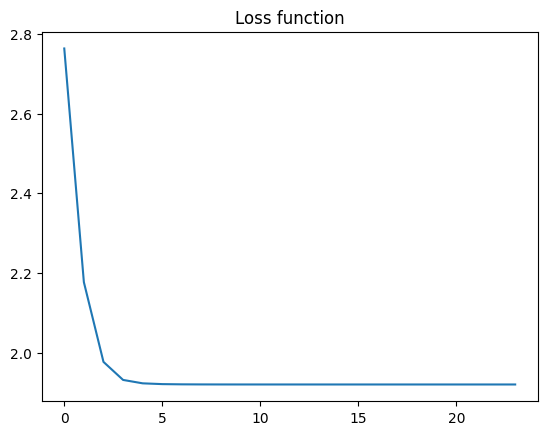

loss functions: 
[2.7632406476328755, 2.1768084884926204, 1.9767193867526895, 1.9314403187353797, 1.9228970857845986, 1.9209386794996004, 1.9203723943745237, 1.9201737145282656, 1.9200944504038782, 1.9200605691640702, 1.9200456064767493, 1.920038901139359, 1.920035876514688, 1.9200345080973777, 1.9200338881118497, 1.9200336070170074, 1.9200334795236056, 1.9200334216854624, 1.9200333954435764, 1.9200333835363919, 1.9200333781332777, 1.920033375681434, 1.9200333745688074, 1.920033374063898]
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0] 4
Accuracy: 0.0% (0 in 0 of 30)
Accuracy: 33.33% (2 in 8 of 30)
Accuracy: 0.0% (0 in 0 of 30)
Accuracy: 0.0% (0 in 12 of 30)
Accuracy: 66.67% (4 in 10 of 30)



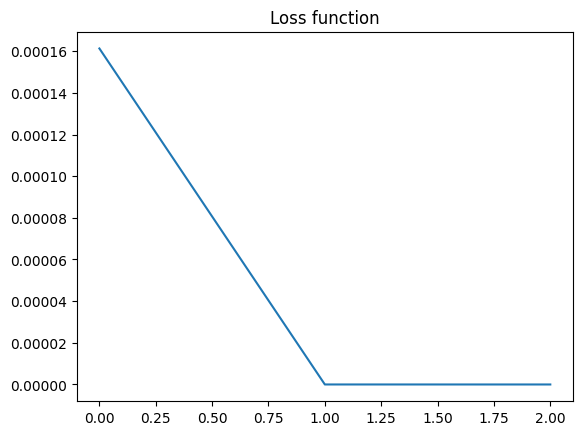

loss functions: 
[0.00016130559712679502, 6.110048035095033e-09, 3.0083496452525638e-18]
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0] 5
Accuracy: 50.0% (3 in 11 of 30)
Accuracy: 50.0% (3 in 17 of 30)
Accuracy: 0.0% (0 in 1 of 30)
Accuracy: 0.0% (0 in 1 of 30)
Accuracy: 0.0% (0 in 0 of 30)



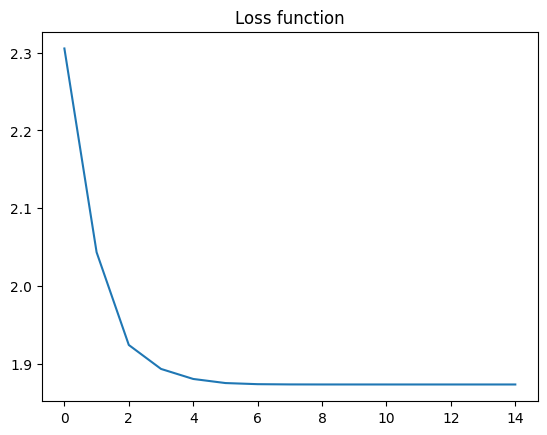

loss functions: 
[2.3054171569113993, 2.0433572096444044, 1.924120270769774, 1.893318645390461, 1.8804157357733384, 1.8751553509111365, 1.8737141404329738, 1.8733998228399569, 1.8733382251147537, 1.8733267962486415, 1.8733247428436177, 1.8733243817147214, 1.8733243191816054, 1.8733243084818618, 1.8733243066684662]
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0] 6
Accuracy: 0.0% (0 in 15 of 30)
Accuracy: 50.0% (3 in 10 of 30)
Accuracy: 50.0% (3 in 4 of 30)
Accuracy: 0.0% (0 in 0 of 30)
Accuracy: 0.0% (0 in 1 of 30)



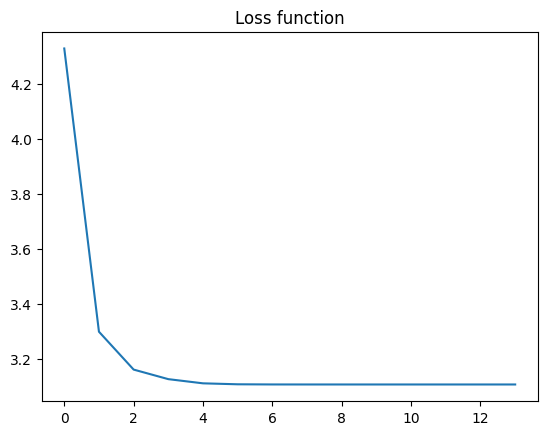

loss functions: 
[4.327216530901325, 3.300064363669412, 3.162728099891283, 3.128056456167588, 3.1128835410812155, 3.1093947103709416, 3.1088249150091203, 3.1087424856868235, 3.1087310989707415, 3.1087295547460303, 3.1087293468362427, 3.1087293189220655, 3.1087293151782767, 3.108729314676372]
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0] 7
Accuracy: 0.0% (0 in 1 of 30)
Accuracy: 0.0% (0 in 0 of 30)
Accuracy: 100.0% (6 in 21 of 30)
Accuracy: 0.0% (0 in 8 of 30)
Accuracy: 0.0% (0 in 0 of 30)



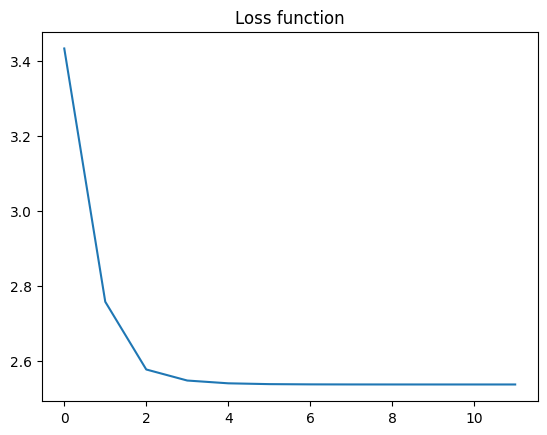

loss functions: 
[3.4332368501850463, 2.7583919858247015, 2.5779028209305843, 2.5484481542995483, 2.5410302883992366, 2.5388685689631743, 2.5382181417779437, 2.5380202460974, 2.5379597695853775, 2.537941254524243, 2.5379355817455496, 2.5379338431086462]
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0] 8
Accuracy: 16.67% (1 in 11 of 30)
Accuracy: 50.0% (3 in 11 of 30)
Accuracy: 33.33% (2 in 7 of 30)
Accuracy: 0.0% (0 in 1 of 30)
Accuracy: 0.0% (0 in 0 of 30)



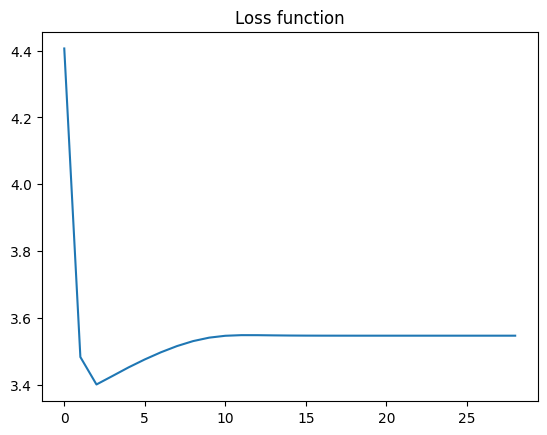

loss functions: 
[4.406155262140985, 3.4832940626959163, 3.4012072209228945, 3.4267297749171473, 3.452521373095763, 3.476132179653781, 3.497480045865723, 3.5160576176543845, 3.5309576037117063, 3.541286125724946, 3.546871926721531, 3.54874224829268, 3.5486592986523413, 3.5480656805761983, 3.5475948331665244, 3.5473382118164656, 3.5472216583394274, 3.5471738898335476, 3.5471554578093487, 3.547148595880432, 3.547146095267919, 3.54714519552355, 3.5471448742319387, 3.547144760017796, 3.547144719525298, 3.5471447051923337, 3.5471447001237664, 3.547144698332378, 3.5471446976994585]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1] 9
Accuracy: 16.67% (1 in 12 of 30)
Accuracy: 83.33% (5 in 18 of 30)
Accuracy: 0.0% (0 in 0 of 30)
Accuracy: 0.0% (0 in 0 of 30)
Accuracy: 0.0% (0 in 0 of 30)



In [12]:
identity_mapping = {iden: idx for idx, iden in enumerate(identity)}
for i in range(len(cluster_fields)):
    __weight = [0] * len(cluster_fields)
    __weight[i] = 1
    ssmc_fcm = SSMC_FCM(
        dataset=dataset, 
        fields_len=data_field_len, 
        fields_weight=__weight,
        n_clusters=5, 
        identity=identity,
        supervised_set=supervised_set, 
    )
    ssmc_fcm.clustering()
    ssmc_fcm.show_loss_function()
    print(__weight, i)
    for cluster in ssmc_fcm.pred_labels:
        count = sum([cluster.count(x) for x in result_set])
        print(f"Accuracy: {round(100 * count / len(result_set), 2)}% ({count} in {len(cluster)} of {len(ssmc_fcm.dataset)})")
    print()